In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and preprocess the data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, index_col=0).transpose()
    weights = {'Strong': 3, 'Good': 2, 'Average': 1, 'None': 0}
    
    # Involvement level columns
    involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                           'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                           'Funding', 'Application-Oriented', 'Number of Members', 
                           'Academic Collaborations', 'System Maturity', 'Demos', 'Industrial Collaborations']
    
    # Map involvement levels to numerical values
    for column in involvement_columns:
        if column in df.columns:
            df[column] = df[column].map(weights).fillna(0)
    
    return df

In [5]:
def calculate_pairwise_similarity(df):
    industry_cols = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 'Robotics', 
                     'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML']
    similarity_matrix = np.zeros((len(df), len(df)))
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                similarity_score = 0
                for col in industry_cols:
                    if df.iloc[i][col] == df.iloc[j][col]:
                        similarity_score += 1
                similarity_matrix[i][j] = similarity_score
    
    return similarity_matrix

In [28]:
# Step 3: Calculate complementary scores
def calculate_complementary_scores(df):
    complementary_cols = ['Number of Members', 'Application-Oriented', 'Academic Collaborations', 
                          'System Maturity', 'Demos', 'Industrial Collaborations']
    complementary_matrix = np.zeros((len(df), len(df)))
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                complementary_score = 0
                for col in complementary_cols:
                    complementary_score += abs(df.iloc[i][col] - df.iloc[j][col])
                complementary_matrix[i][j] = complementary_score
    
    # Invert the scores to make them comparable with similarity scores (lower means more complementary)
    max_score = np.max(complementary_matrix)
    complementary_matrix = max_score - complementary_matrix
    
    return complementary_matrix

In [29]:
# Step 4: Combine similarity and complementary scores
def combine_scores(industry_similarity, complementary_scores, alpha=0.5):
    combined_matrix = alpha * industry_similarity + (1 - alpha) * complementary_scores
    return combined_matrix

In [56]:
# Step 3: Apply clustering based on similarity matrix
def apply_clustering(similarity_matrix, num_clusters):
    clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='complete')
    labels = clustering.fit_predict(1 - (similarity_matrix / np.max(similarity_matrix)))
    return labels


In [57]:
# Step 4: Calculate the average ratings for each feature within each cluster
def calculate_cluster_averages(df, labels):
    df['cluster'] = labels
    cluster_averages = df.groupby('cluster').mean().drop(columns='cluster', errors='ignore')
    return cluster_averages

In [19]:
# Step 5: Identify common strengths in each cluster
def identify_common_strengths(cluster_averages):
    common_strengths = (cluster_averages >= 1.5)  # Considering 'Good' (2) and 'Strong' (3) as strengths
    return common_strengths

In [20]:
# Define the feature weights (if custom scoring is needed)
feature_weights = {
    'Security': 3,
    'Humanities': 3,
    'Nat. Sci': 3,
    'Health': 3,
    'AI Ethics': 3,
    'Big Data': 3,
    'Robotics': 3,
    'Documents': 3,
    'Multimedia': 3,
    'NLP': 3,
    'KRR': 3,
    'Graphs': 3,
    'DL/ML': 3,
    'Number of Members': 1,
    'Application-Oriented': 2,
    'Academic Collaborations': 2,
    'System Maturity': 2,
    'Demos': 2,
    'Industrial Collaborations': 2
}

In [66]:
# Path to the CSV file
filepath = 'data/team_stats.csv'

# Load and preprocess the data
df = load_and_preprocess_data(filepath)

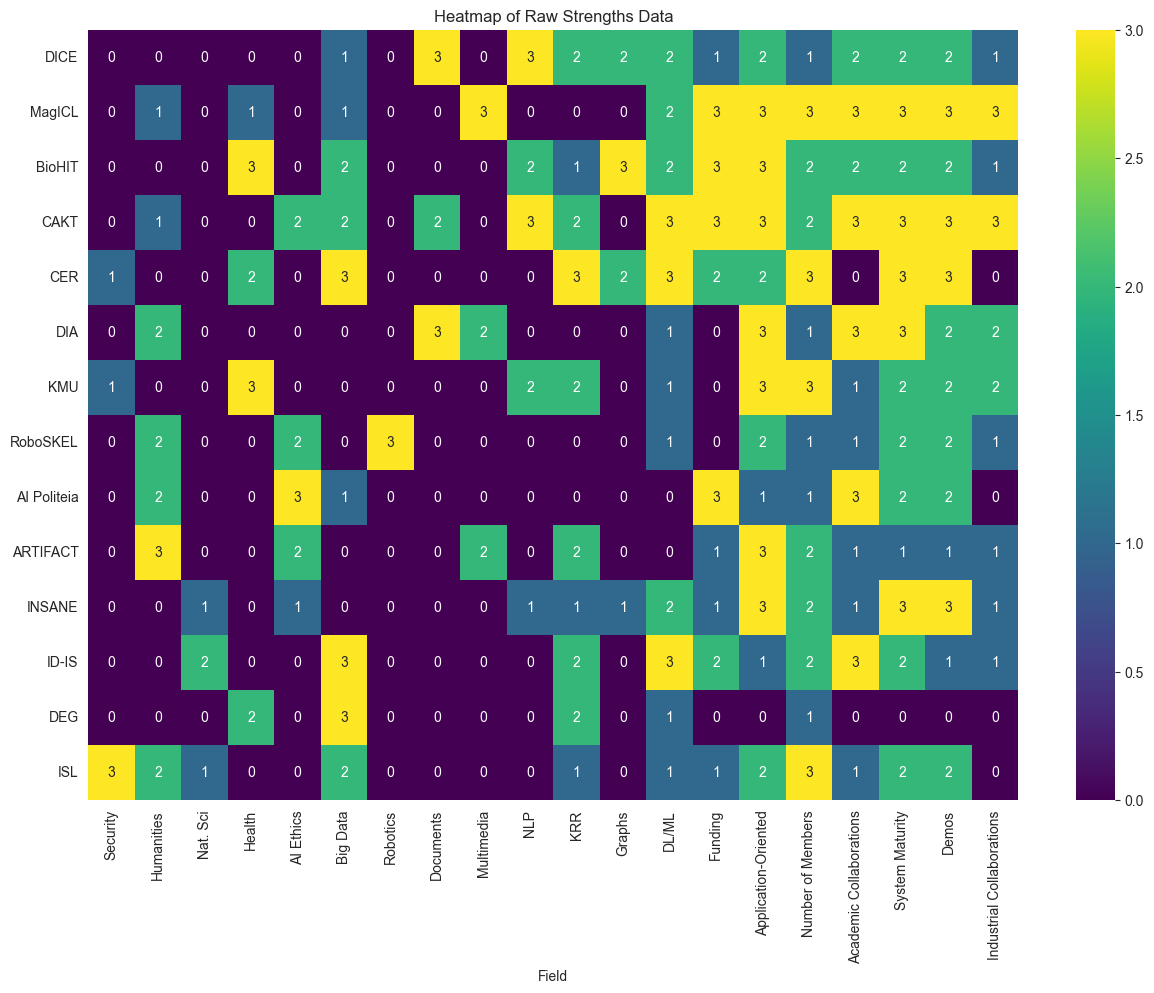

In [71]:
# Plot heatmap of the original strengths data
plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='viridis')
plt.title('Heatmap of Raw Strengths Data')
plt.show()


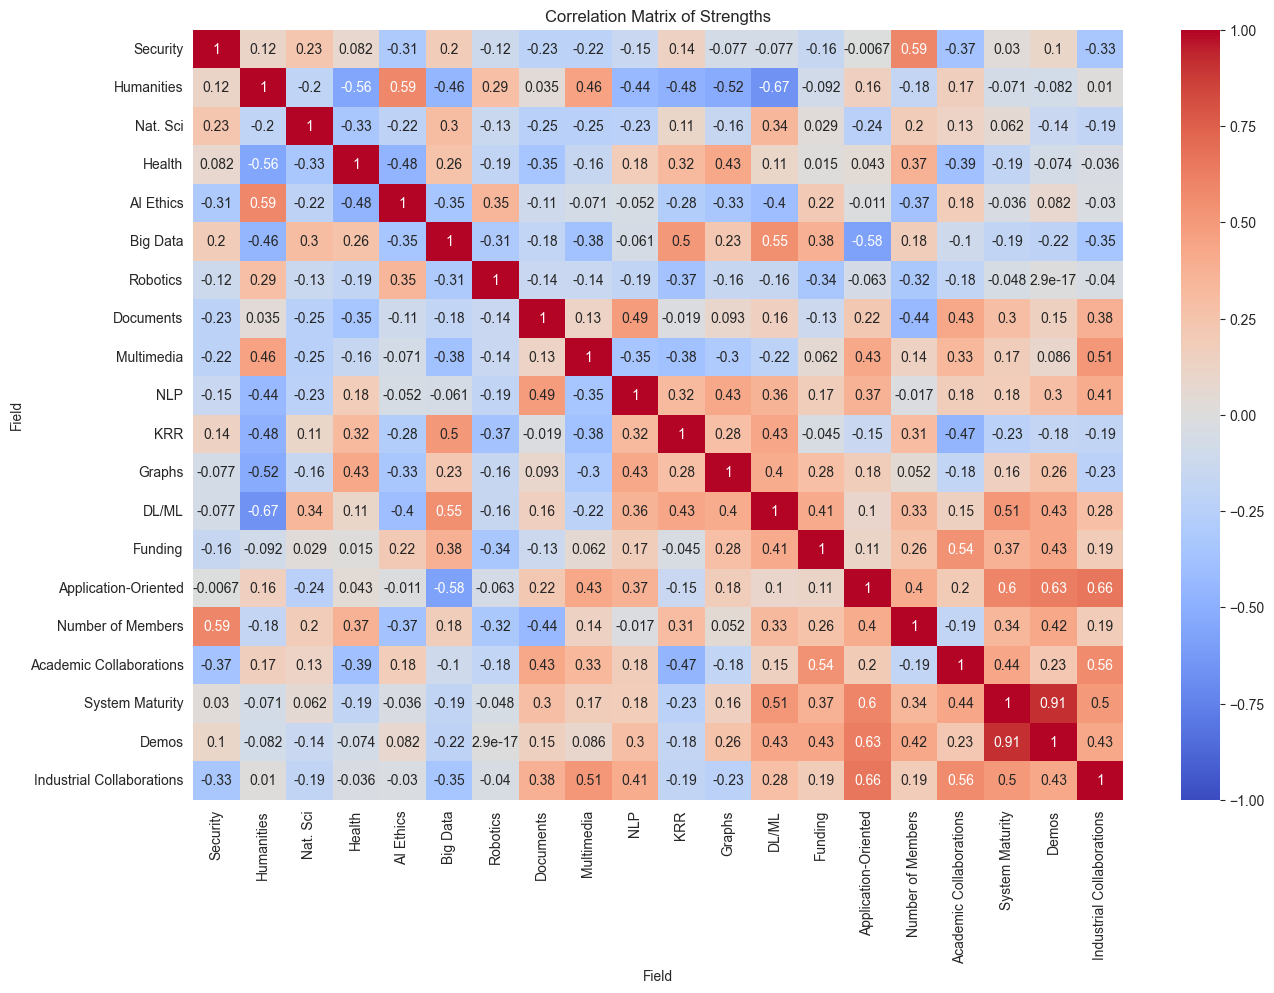

In [72]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Strengths')
plt.show()


In [59]:
# Calculate pairwise similarity scores
industry_scores = calculate_pairwise_similarity(df)

complementary_scores = calculate_complementary_scores(df)

combined_scores = combine_scores(industry_scores,complementary_scores, alpha=0.5)

In [76]:
num_clusters = 5  # Define the number of clusters
labels_ind = apply_clustering(industry_scores, num_clusters)
df['cluster'] = labels_ind

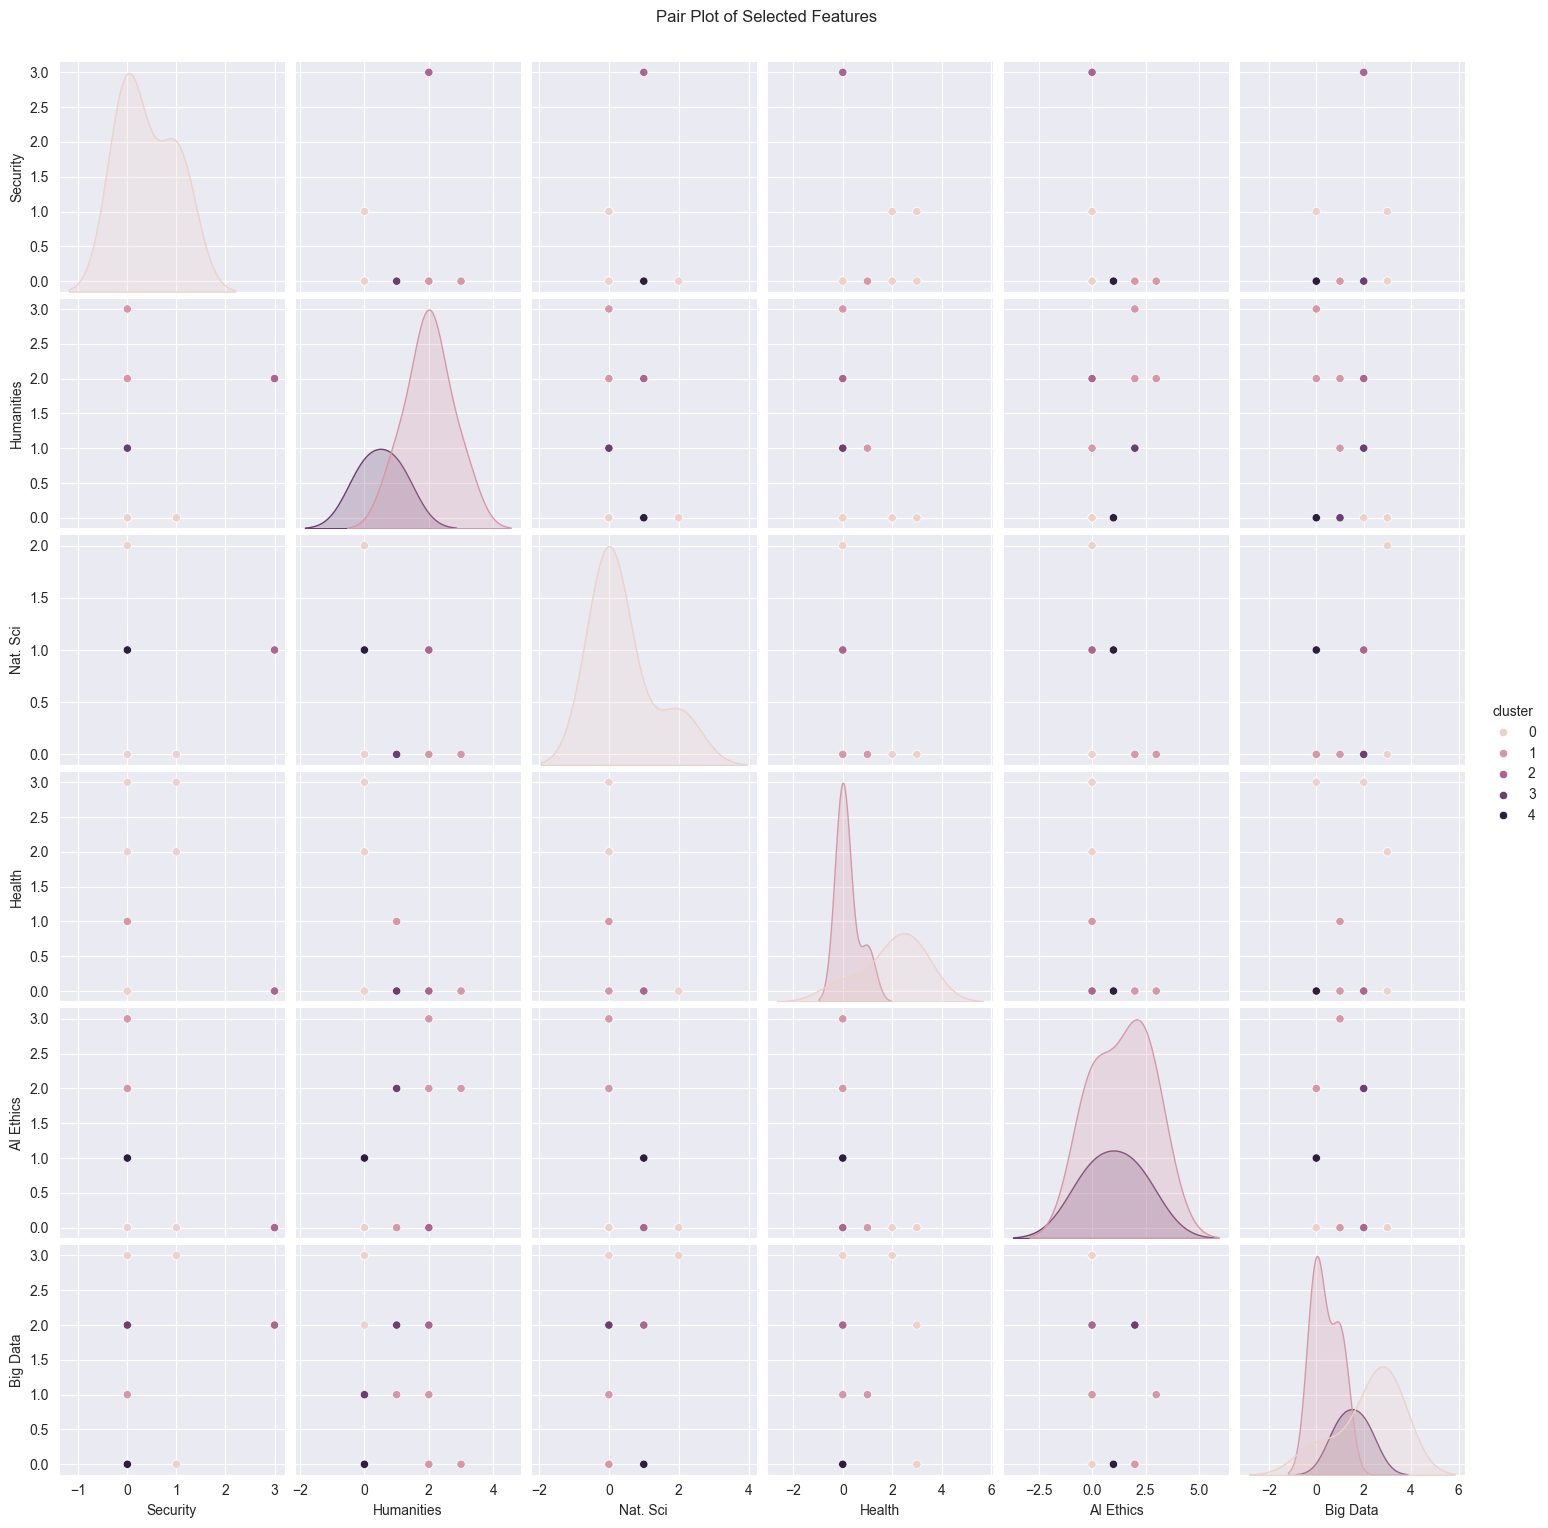

In [77]:
# Plot pairplot of selected features
sns.pairplot(df, vars=['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data'], hue='cluster')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()


In [81]:
def similarity_visual(scores):

    num_clusters = 5  # Define the number of clusters
    labels_ind = apply_clustering(scores, num_clusters)
    df['cluster'] = labels_ind
    
    # Calculate the average ratings for each feature within each cluster
    cluster_averages = calculate_cluster_averages(df, labels_ind)
    
    # Identify common strengths in each cluster
    common_strengths = identify_common_strengths(cluster_averages)
    
    # Display the cluster averages for analysis
    print("Cluster Average Ratings:")
    print(cluster_averages)
    
    # Display the common strengths for analysis
    print("Common Strengths in Clusters:")
    print(common_strengths)
    
    # Visualize the common strengths
    # Transpose for easier plotting
    common_strengths_t = common_strengths.T
    
    # Plot common strengths
    plt.figure(figsize=(15, 8))
    sns.heatmap(common_strengths_t, annot=True, cmap='coolwarm', cbar=False)
    plt.title('Common Strengths in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Feature')
    plt.show()
    
    # Plot heatmap of cluster averages
    plt.figure(figsize=(15, 10))
    sns.heatmap(cluster_averages, annot=True, cmap='viridis')
    plt.title('Heatmap of Cluster Averages')
    plt.show()



Cluster Average Ratings:
Field    Security  Humanities  Nat. Sci    Health  AI Ethics  Big Data  \
cluster                                                                  
0        0.000000    1.000000  0.333333  0.500000   0.833333  1.166667   
1        1.666667    0.666667  0.333333  1.666667   0.000000  1.666667   
2        0.000000    0.000000  0.000000  2.000000   0.000000  3.000000   
3        0.000000    1.500000  0.500000  0.000000   1.500000  0.000000   
4        0.000000    1.000000  0.000000  0.500000   1.000000  1.500000   

Field    Robotics  Documents  Multimedia       NLP       KRR    Graphs  \
cluster                                                                  
0             0.5        1.0    0.333333  0.833333  0.833333  0.833333   
1             0.0        0.0    0.000000  0.666667  2.000000  0.666667   
2             0.0        0.0    0.000000  0.000000  2.000000  0.000000   
3             0.0        0.0    1.000000  0.500000  1.500000  0.500000   
4           

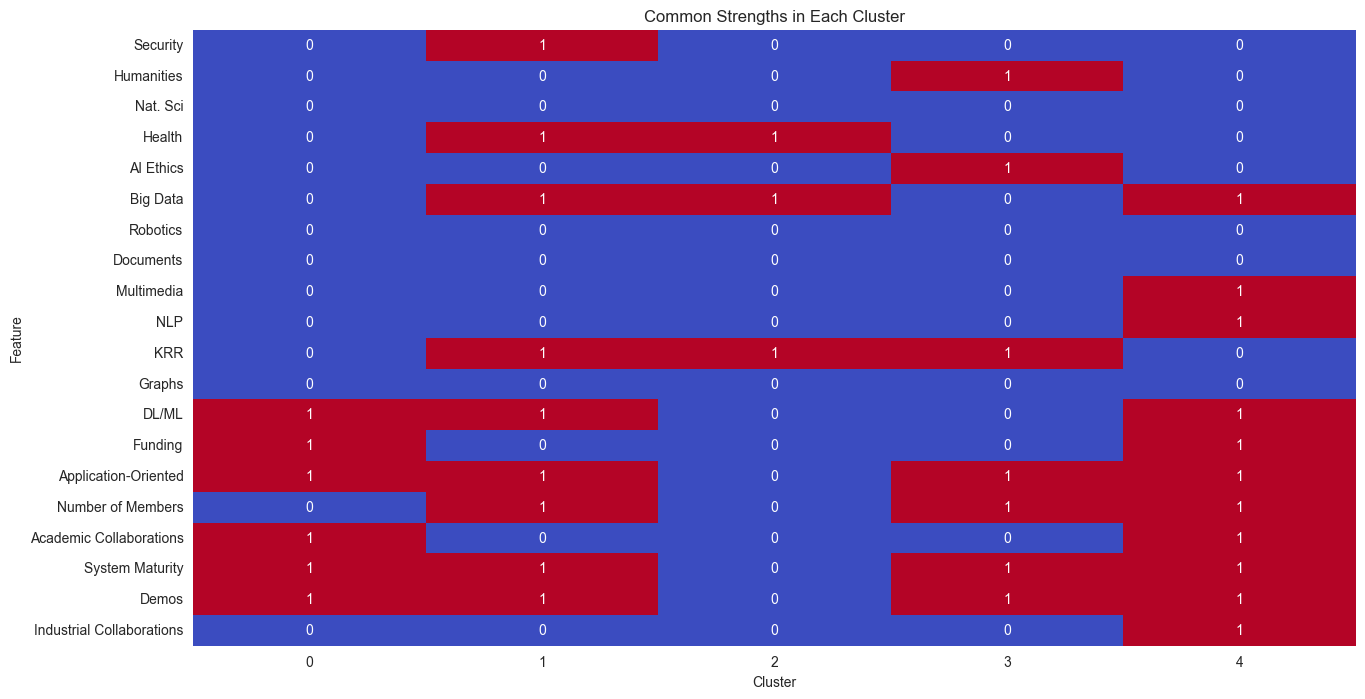

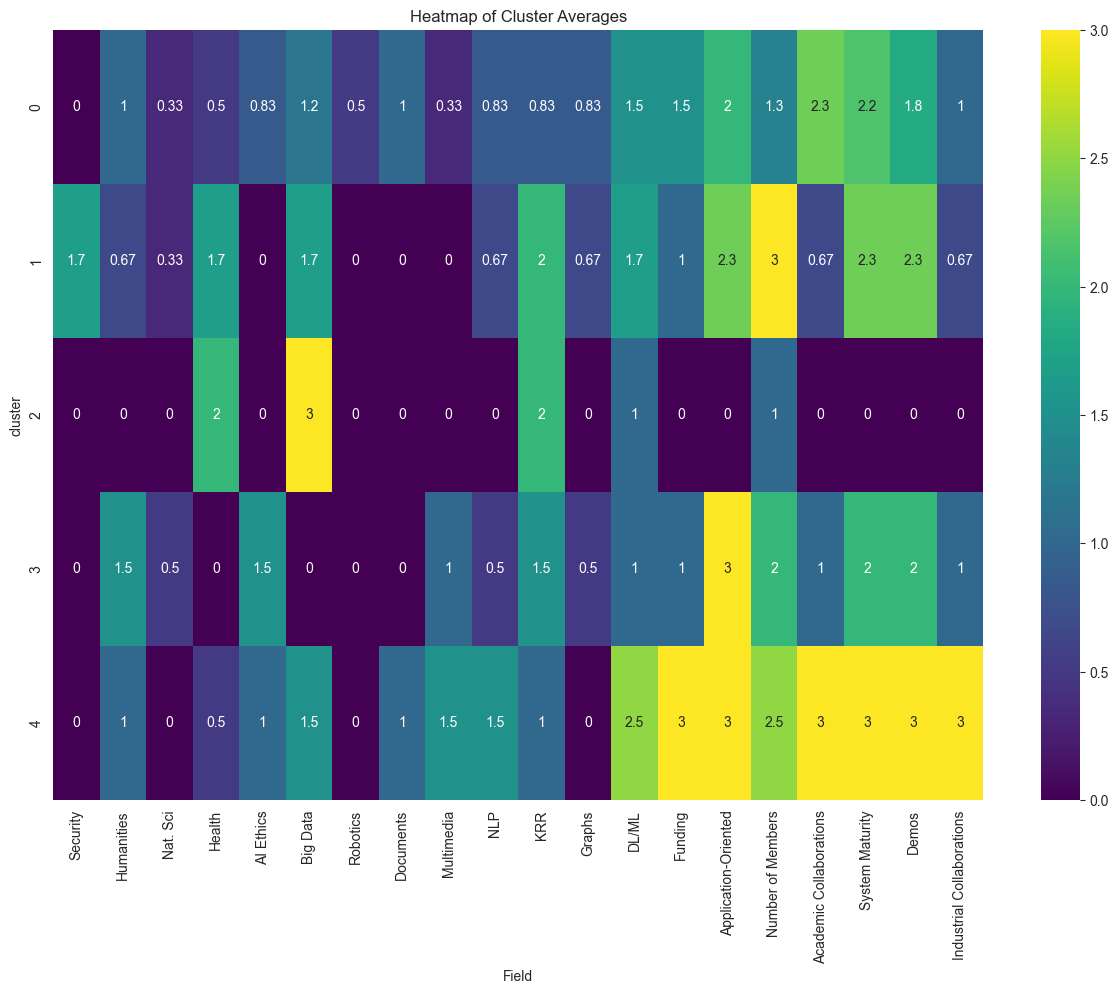

In [82]:
similarity_visual(combined_scores)

In [80]:
# Generate profiles for each cluster
def profile_clusters(df):
    profiles = df.groupby('cluster').agg(['mean', 'std', 'min', 'max'])
    return profiles

cluster_profiles = profile_clusters(df)
print("Cluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
Field    Security                     Humanities                      \
             mean       std  min  max       mean       std  min  max   
cluster                                                                
0        0.000000  0.000000  0.0  0.0   1.000000  1.095445  0.0  2.0   
1        1.666667  1.154701  1.0  3.0   0.666667  1.154701  0.0  2.0   
2        0.000000       NaN  0.0  0.0   0.000000       NaN  0.0  0.0   
3        0.000000  0.000000  0.0  0.0   1.500000  2.121320  0.0  3.0   
4        0.000000  0.000000  0.0  0.0   1.000000  0.000000  1.0  1.0   

Field    Nat. Sci            ... System Maturity          Demos            \
             mean       std  ...             min  max      mean       std   
cluster                      ...                                            
0        0.333333  0.816497  ...             2.0  3.0  1.833333  0.408248   
1        0.333333  0.577350  ...             2.0  3.0  2.333333  0.577350   
2        0.000000   

In [63]:
# Clustering using only industry similarity
num_clusters = 5
industry_labels = apply_clustering(industry_scores, num_clusters)
df['industry_cluster'] = industry_labels

# Clustering using only complementary scores
complementary_labels = apply_clustering(complementary_scores, num_clusters)
df['complementary_cluster'] = complementary_labels

# Calculate and compare cluster averages for different methods
industry_cluster_averages = calculate_cluster_averages(df, industry_labels)
complementary_cluster_averages = calculate_cluster_averages(df, complementary_labels)


In [64]:
print("Industry-based Cluster Averages:")
print(industry_cluster_averages)

print("Complementary-based Cluster Averages:")
print(complementary_cluster_averages)


Industry-based Cluster Averages:
Field    Security  Humanities  Nat. Sci  Health  AI Ethics  Big Data  \
cluster                                                                
0             0.4         0.0       0.4     2.0        0.0       2.2   
1             0.0         2.0       0.0     0.2        1.4       0.4   
2             3.0         2.0       1.0     0.0        0.0       2.0   
3             0.0         0.5       0.0     0.0        1.0       1.5   
4             0.0         0.0       1.0     0.0        1.0       0.0   

Field    Robotics  Documents  Multimedia  NLP  ...  DL/ML  Funding  \
cluster                                        ...                   
0             0.0        0.0         0.0  0.8  ...    2.0      1.4   
1             0.6        0.6         1.4  0.0  ...    0.8      1.4   
2             0.0        0.0         0.0  0.0  ...    1.0      1.0   
3             0.0        2.5         0.0  3.0  ...    2.5      2.0   
4             0.0        0.0         0.0  

In [65]:
# Compare common strengths
industry_common_strengths = identify_common_strengths(industry_cluster_averages)
complementary_common_strengths = identify_common_strengths(complementary_cluster_averages)

print("Industry-based Common Strengths:")
print(industry_common_strengths)

print("Complementary-based Common Strengths:")
print(complementary_common_strengths)

Industry-based Common Strengths:
Field    Security  Humanities  Nat. Sci  Health  AI Ethics  Big Data  \
cluster                                                                
0           False       False     False    True      False      True   
1           False        True     False   False      False     False   
2            True        True     False   False      False      True   
3           False       False     False   False      False      True   
4           False       False     False   False      False     False   

Field    Robotics  Documents  Multimedia    NLP  ...  DL/ML  Funding  \
cluster                                          ...                   
0           False      False       False  False  ...   True    False   
1           False      False       False  False  ...  False    False   
2           False      False       False  False  ...  False    False   
3           False       True       False   True  ...   True     True   
4           False      False  